# Introduction

In late 2015 a paper was released titled ["A Neural Algorithm of Artistic Style"](http://arxiv.org/abs/1508.06576), authored by Leon Gatys, Alexander Ecker and Matthias Bethge, that created a flurry of online discussion (e.g. [link 1](http://qz.com/495614/computers-can-now-paint-like-van-gogh-and-picasso/), [link 2](http://www.dailymail.co.uk/sciencetech/article-3214634/The-algorithm-learn-copy-artist-Neural-network-recreate-snaps-style-Van-Gogh-Picasso.html), [link 3](https://www.technologyreview.com/s/601424/algorithm-clones-van-goghs-artistic-style-and-pastes-it-onto-other-images-movies/)). The reason was simple: it worked fantastically well.

Here I look to recreate a basic version of the same neural network using Tensor Flow as a way to learn more about neural networks and coding them in Python. Follow along if you are interested too!

# Requirements
I ran this code on a computer with dedicated GPU memory (using AWS EC2) with TensorFlow installed and configured to work with the GPU. This allowed very quick training times. The GPU is not a requirement but I am not sure how long this code will take to run on a CPU.

As noted in the methods section of the paper, the authors used the [VGG-network](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) as a basis. To use the same for our implementation below we will need to download the [VGG-19](http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat) model.

Apart from the above, the other requirements are the regular Python libraries: Scipy and Numpy.

In [1]:
import os
import numpy as np
from scipy import io, misc
import tensorflow as tf
from matplotlib import pyplot, image
%matplotlib inline

# Set up
The idea is to train a neural network to recognise stylistic patterns and even details like strokes from an input image. Within the neural network this is represented as a combination of responses to various distinct filters (from the CNN) and a representation of the correlations between the different responses. We will refer to these as features.

For this demonstration I will use one of my favourite paintings, *The School of Athens* by Raphael, to train the neural network.

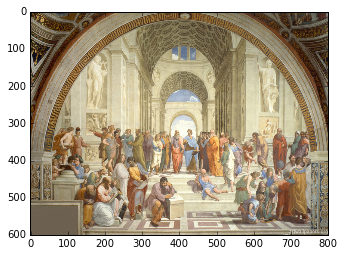

In [2]:
paintingStyleImage = image.imread("schoolofathens.jpg")
pyplot.imshow(paintingStyleImage)

To generate a new image in the same style as the painting above, the algorithm then tries to minimise the difference the features of the new image and the painting we are trying to immitate. 

For this example we will use the following image that we want to convert to an immitation.

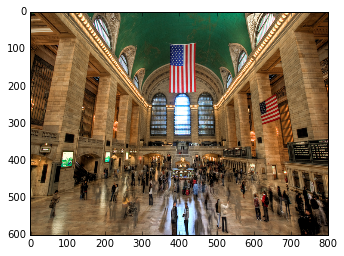

In [3]:
inputImage = image.imread("grandcentral.jpg")
pyplot.imshow(inputImage)

Lets also set the ouput image size.

In [4]:
outputWidth = 800
outputHeight = 600

# Algorithm
## Set the constants
- The `beta` is a measure of how much of the original input image content to retain. (higher is more retention)
- The `alpha` is a measure of how much of the original style of the input image to retain. (higher is more retention)
- The `noise ratio` is a measure of the weight of the white noise image generated from the input image.

You can play around with these constants to see the impact on the resulting image.

In [5]:
# Beta constant 
beta = 5
# Alpha constant
alpha = 100
# Noise ratio
noiseRatio = 0.6

## Load the VGG layer models

In [6]:
# Name of the VGG-19 model
vggModel19File = 'imagenet-vgg-verydeep-19.mat'
# Mean VGG-19 image
meanImage19 = np.array([103.939, 116.779, 123.68]).reshape((1,1,1,3))

## The Model
As the paper states, the feature space provided by the 16 convolutional and the 5 pooling layers of the VGG-19 layer model was used. Also none of the fully connected layers were used, and the max-pooling operation is replaced by the average-pooling operation in order to improve the gradient flow (and apparently more appealing results).

In [7]:
# Load the VGG-16 model
vgg19 = io.loadmat(vggModel19File)

# Get the layers of the VGG-16 model
vgg19Layers = vgg19['layers']

In [8]:
#vgg19Layers

In [9]:
# A function to get the weights of the VGG layers
def vbbWeights(layerNumber):
    W = vgg19Layers[0][layerNumber][0][0][2][0][0]
    W = tf.constant(W)
    return W

def vbbConstants(layerNumber):
    b = vgg19Layers[0][layerNumber][0][0][2][0][1].T
    b = tf.constant(np.reshape(b, (b.size)))
    return b

# Graph of the model
modelGraph = {}
modelGraph['input'] = tf.Variable(np.zeros((1, outputHeight, outputWidth, 3)), dtype = 'float32')
modelGraph['conv1_1'] = tf.nn.relu(tf.nn.conv2d(modelGraph['input'], filter = vbbWeights(0), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(0))
modelGraph['conv1_2'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv1_1'], filter = vbbWeights(2), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(2))
modelGraph['avgpool1'] = tf.nn.avg_pool(modelGraph['conv1_2'], ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
modelGraph['conv2_1'] = tf.nn.relu(tf.nn.conv2d(modelGraph['avgpool1'], filter = vbbWeights(5), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(5))
modelGraph['conv2_2'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv2_1'], filter = vbbWeights(7), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(7))
modelGraph['avgpool2'] = tf.nn.avg_pool(modelGraph['conv2_2'], ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
modelGraph['conv3_1'] = tf.nn.relu(tf.nn.conv2d(modelGraph['avgpool2'], filter = vbbWeights(10), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(10))
modelGraph['conv3_2'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv3_1'], filter = vbbWeights(12), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(12))
modelGraph['conv3_3'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv3_2'], filter = vbbWeights(14), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(14))
modelGraph['conv3_4'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv3_3'], filter = vbbWeights(16), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(16))
modelGraph['avgpool3'] = tf.nn.avg_pool(modelGraph['conv3_4'], ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
modelGraph['conv4_1'] = tf.nn.relu(tf.nn.conv2d(modelGraph['avgpool3'], filter = vbbWeights(19), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(19))
modelGraph['conv4_2'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv4_1'], filter = vbbWeights(21), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(21))
modelGraph['conv4_3'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv4_2'], filter = vbbWeights(23), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(23))
modelGraph['conv4_4'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv4_3'], filter = vbbWeights(25), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(25))
modelGraph['avgpool4'] = tf.nn.avg_pool(modelGraph['conv4_4'], ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
modelGraph['conv5_1'] = tf.nn.relu(tf.nn.conv2d(modelGraph['avgpool4'], filter = vbbWeights(28), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(28))
modelGraph['conv5_2'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv5_1'], filter = vbbWeights(30), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(30))
modelGraph['conv5_3'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv5_2'], filter = vbbWeights(32), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(32))
modelGraph['conv5_4'] = tf.nn.relu(tf.nn.conv2d(modelGraph['conv5_3'], filter = vbbWeights(34), strides = [1, 1, 1, 1], padding = 'SAME') + vbbConstants(34))
modelGraph['avgpool5'] = tf.nn.avg_pool(modelGraph['conv5_4'], ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

# Print graph
modelGraph

{'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 300, 400, 64) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 150, 200, 128) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 75, 100, 256) dtype=float32>,
 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 38, 50, 512) dtype=float32>,
 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 19, 25, 512) dtype=float32>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 600, 800, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 600, 800, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 300, 400, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 300, 400, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv4_1': <tf.T

We will also define the loss equations from the paper.

In [10]:
# Squared-error loss of content between the two feature representations
def sqErrorLossContent(session, modelGraph, layer):
    p = session.run(modelGraph[layer])
    N = p.shape[3]
    M = p.shape[1] * p.shape[2]
    return (1 / (4 * N * M)) * tf.reduce_sum(tf.pow(modelGraph[layer] - session.run(modelGraph[layer]), 2))

# Squared-error loss of style between the two feature representations
styleLayers = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2),
]
def sqErrorLossStyle(session, modelGraph):
    def intermediateCalc(x, y):
        N = x.shape[3]
        M = x.shape[1] * x.shape[2]
        A = tf.matmul(tf.transpose(tf.reshape(x, (M, N))), tf.reshape(x, (M, N)))
        G = tf.matmul(tf.transpose(tf.reshape(y, (M, N))), tf.reshape(y, (M, N)))
        return (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
    E = [intermediateCalc(session.run(modelGraph[layerName]), model[layerName]) for layerName, _ in styleLayers]
    W = [w for _, w in styleLayers]
    return sum([W[layerNumber] * E[layerNumber] for layerNumber in range(len(styleLayers))])

In [11]:
session = tf.InteractiveSession()

The convnet requires an extra dimension to be added to the image. Also the VGG-19 model expects the image we want to convert to an immitation to have the VGG-19 model mean values subtracted from it.

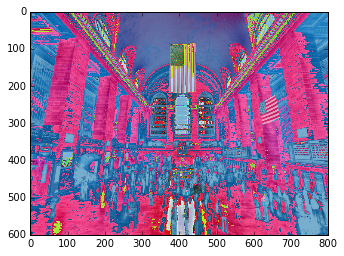

In [12]:
# Addition of extra dimension to image
inputImage = np.reshape(inputImage, ((1,) + inputImage.shape))
inputImage = inputImage - meanImage19
# Display image
pyplot.imshow(inputImage[0])

Do the same to the style image.

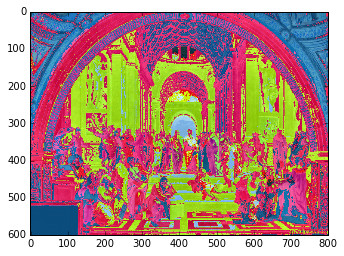

In [13]:
# Addition of extra dimension to image
paintingStyleImage = np.reshape(paintingStyleImage, ((1,) + paintingStyleImage.shape))
paintingStyleImage = paintingStyleImage - meanImage19
# Display image
pyplot.imshow(paintingStyleImage[0])

In [14]:
model = modelGraph
#print(model)

Generate the white noise and content presentation mixed image which will be the basis for the algorithm to "paint".

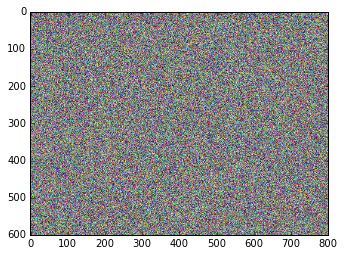

In [15]:
imageNoise = np.random.uniform(-20, 20, (1, outputHeight, outputWidth, 3)).astype('float32')
pyplot.imshow(imageNoise[0])

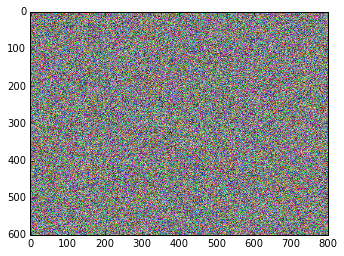

In [16]:
inputImage = imageNoise * noiseRatio + inputImage * (1 - noiseRatio)
pyplot.imshow(inputImage[0])

In [17]:
session.run(tf.initialize_all_variables())

In [18]:
session.run(model['input'].assign(inputImage))

array([[[[ 43.30503464,  38.37237167,  51.75156784],
         [ 50.74325562,  49.28265381,  41.6300621 ],
         [ 48.19823837,  56.44729996,  49.98372269],
         ..., 
         [-18.72398186, -36.9907074 , -56.25692368],
         [-24.57284355, -34.80892944, -36.62465668],
         [ -5.72399473, -42.19080734, -55.97570801]],

        [[ 38.15742493,  41.754673  ,  38.88946533],
         [ 36.60228729,  53.87473679,  40.35443497],
         [ 51.064888  ,  52.54706192,  50.18244171],
         ..., 
         [-24.56476212, -42.59817505, -45.05791473],
         [-11.79580402, -23.82549286, -39.40297699],
         [  3.93327546, -18.63686371, -52.42227173]],

        [[  3.78462315,  -1.2817471 ,  -5.90330744],
         [ 25.78535271,  19.25126648,  32.49608231],
         [ 35.47795868,  40.51142502,  48.2921524 ],
         ..., 
         [-10.03840828, -18.66027832, -39.13789749],
         [ -6.56481457, -17.41117859, -38.14156342],
         [-20.72511864, -25.84183884, -55.36753082

In [19]:
contentLoss = sqErrorLossContent(session, model, 'conv4_2')

In [20]:
session.run(model['input'].assign(paintingStyleImage))
styleLoss = sqErrorLossStyle(session, model)

In [21]:
totalLoss = beta * contentLoss + alpha * styleLoss

The content is built from one layer, and the style is built from five layers. We then minimize the `totalLoss`, as written above.

In [22]:
optimizer = tf.train.AdamOptimizer(2.0)
trainStep = optimizer.minimize(totalLoss)

In [23]:
session.run(tf.initialize_all_variables())
session.run(model['input'].assign(inputImage))

array([[[[ 43.30503464,  38.37237167,  51.75156784],
         [ 50.74325562,  49.28265381,  41.6300621 ],
         [ 48.19823837,  56.44729996,  49.98372269],
         ..., 
         [-18.72398186, -36.9907074 , -56.25692368],
         [-24.57284355, -34.80892944, -36.62465668],
         [ -5.72399473, -42.19080734, -55.97570801]],

        [[ 38.15742493,  41.754673  ,  38.88946533],
         [ 36.60228729,  53.87473679,  40.35443497],
         [ 51.064888  ,  52.54706192,  50.18244171],
         ..., 
         [-24.56476212, -42.59817505, -45.05791473],
         [-11.79580402, -23.82549286, -39.40297699],
         [  3.93327546, -18.63686371, -52.42227173]],

        [[  3.78462315,  -1.2817471 ,  -5.90330744],
         [ 25.78535271,  19.25126648,  32.49608231],
         [ 35.47795868,  40.51142502,  48.2921524 ],
         ..., 
         [-10.03840828, -18.66027832, -39.13789749],
         [ -6.56481457, -17.41117859, -38.14156342],
         [-20.72511864, -25.84183884, -55.36753082

In [24]:
# Number of iterations to run.
iterations = 2000

In [ ]:
session.run(tf.initialize_all_variables())
session.run(model['input'].assign(inputImage))

for iters in range(iterations):
    session.run(trainStep)
    if iters%50 == 0:        
        filename = 'output%d.png' % (iters)
        im = mixedImage + meanImage19
        im = im[0]
        im = np.clip(im, 0, 255).astype('uint8')
        misc.imsave(filename, im)

im = mixedImage + meanImage19
im = im[0]
im = np.clip(im, 0, 255).astype('uint8')
misc.imsave('finalImage.png', im)

# Conclusion
There is a lot to play around with in the code above including the number of iterations, the weights of each layer etc. I will not cover that in this notebook for now. Perhaps I will create another notebook exploring this. For now I will conclude with a gif animation of our neural network "painting" overtime.

![Output Animation](./outputAnimation.gif)